In [16]:
import pandas as pd
import sklearn
import tensorflow as tf
import numpy as np

from math import sqrt
from math import floor
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot as plt
from pylab import rcParams

from matplotlib import rc
from pandas.plotting import register_matplotlib_converters


%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

from keras.utils import plot_model
import pydot_ng as pydot

from attention import Attention

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

import keras


from numpy import array

from keras.models import Sequential
from keras.layers import LSTM

from keras.layers import Dense
from keras.layers import RepeatVector

from keras.layers import TimeDistributed
from keras.layers import Dropout

from keras.utils import plot_model
import pydot_ng as pydot

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

from keras.utils import plot_model

In [66]:
from scipy.sparse import csgraph
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [18]:
# Load training data set from CSV file
df = pd.read_csv('en_scaled.csv')
df = df.iloc[:,1:-1]
dataset = df[['ax_mps2_SSFDR_intpd','pitch_rm_deg_SSFDR_intpd','ias_rm_mps_SSFDR_intpd',
              'throttle_dmd_pteng_per_SSFDR','ecu_load_pteng_per_SSFDR', 
              'ecu_fuel_fl_rt_pteng_ltph_SSFDR','ecu_rpm_pteng_SSFDR']]
dataset = dataset.dropna()
values = dataset.values


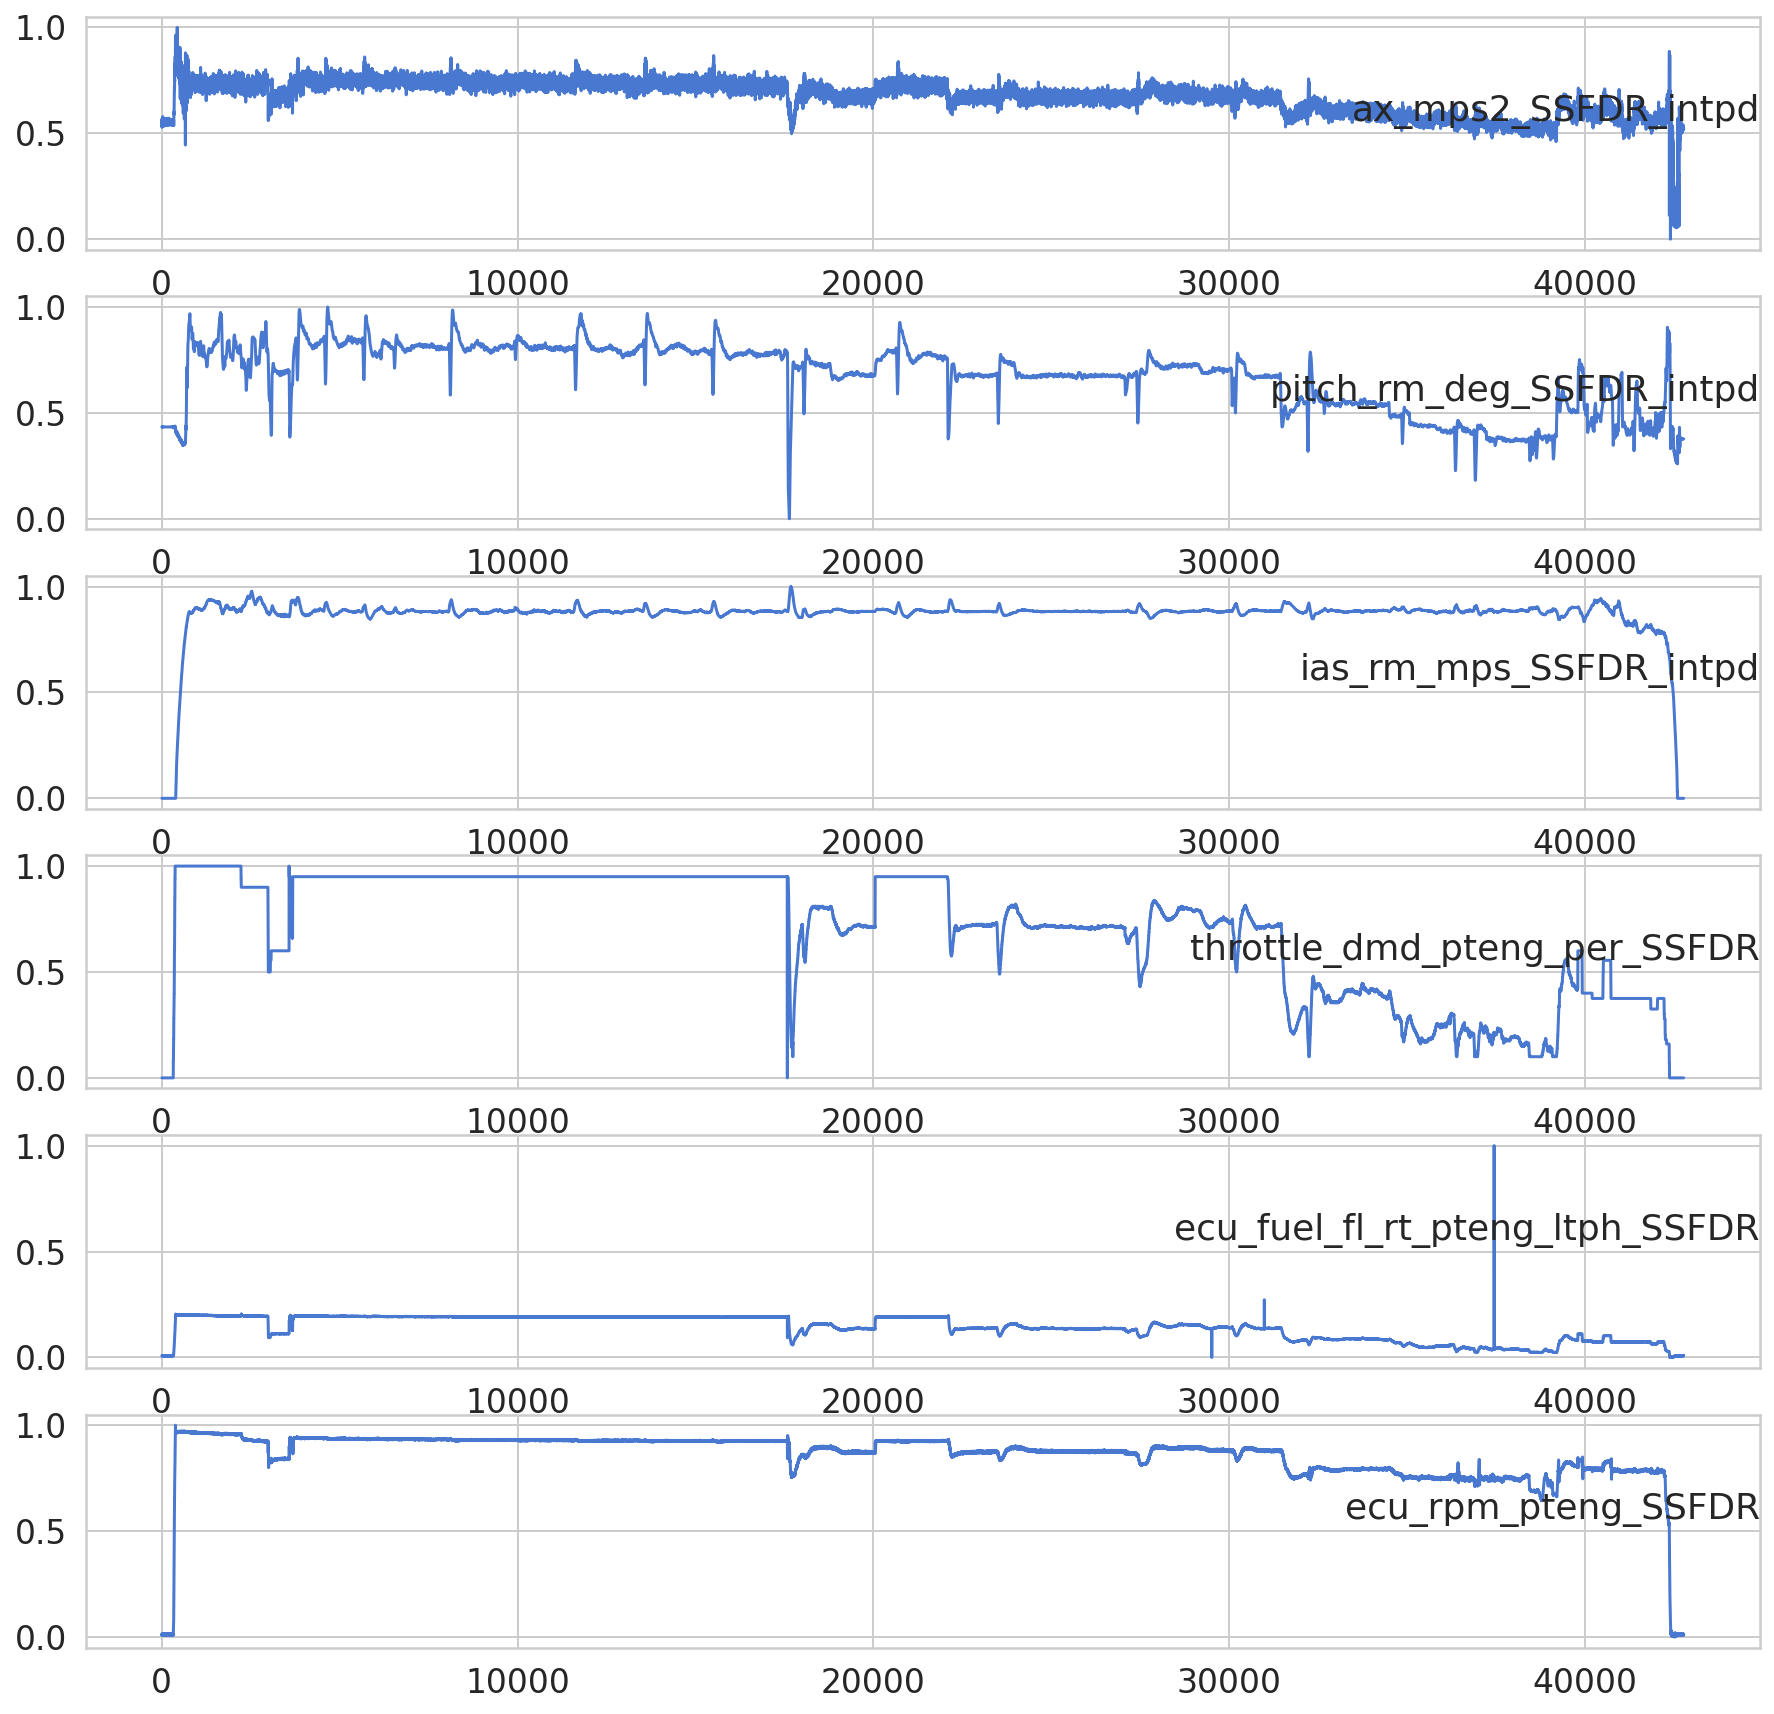

In [19]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5,6]
i = 1

# plot each column
fig1 = plt.figure(figsize=(15,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
#     plt.grid()
    i += 1

plt.show()

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
##Data preparation

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
print('**********************************************************************************************')
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11,12]], axis=1, inplace=True)
print(reframed.head())

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.566839   0.433489        0.0        0.0       0.02   0.007475   
2       0.567173   0.433489        0.0        0.0       0.02   0.008009   
3       0.547592   0.433489        0.0        0.0       0.02   0.008009   
4       0.528025   0.433489        0.0        0.0       0.02   0.008009   
5       0.535843   0.433489        0.0        0.0       0.02   0.007475   
...          ...        ...        ...        ...        ...        ...   
42768   0.532186   0.376896        0.0        0.0       0.02   0.008009   
42769   0.530913   0.376896        0.0        0.0       0.02   0.008009   
42770   0.523458   0.376896        0.0        0.0       0.02   0.008009   
42771   0.520994   0.376896        0.0        0.0       0.02   0.007475   
42772   0.523715   0.376896        0.0        0.0       0.02   0.007475   

       var7(t-1)   var1(t)   var2(t)  var3(t)  var4(t)  var5(t)   var6(t)  \
1       0.014033  0.56

In [22]:
# split into train and test sets
values = reframed.values
n_train_msec = floor(len(dataset)*0.8)
train = values[:n_train_msec, :]
test = values[n_train_msec:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34218, 1, 7) (34218,) (8554, 1, 7) (8554,)


In [23]:
# #Model
# # design network
# lstm_encoder = Sequential()
# lstm_encoder.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
# Attention(name='attention_weight'),
# # lstm_encoder.add(RepeatVector(train_X.shape[2]))
# # lstm_encoder.add(LSTM(25,return_sequences=False))
# lstm_encoder.add(Dense(3))

# lstm_decoder = Sequential()
# lstm_decoder.add(Dense(3))
# lstm_decoder.add(RepeatVector(n=train_X.shape[1])) #repeat vector of time dimension
# lstm_decoder.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences =False))
# Attention(name='attention_weight'),
# lstm_decoder.add(Dense(7))



# lstm_ae =Sequential([lstm_decoder, lstm_decoder])

In [46]:
latent_dim = 3
inter_dim =  100

inputs= Input(shape=(train_X.shape[1], train_X.shape[2]))

h=LSTM(inter_dim)(inputs)
z= Dense(latent_dim)(h)

In [47]:
encoder = Model(inputs= [inputs], outputs = [z])

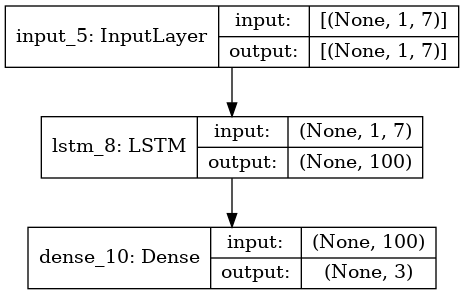

In [48]:
plot_model(encoder, show_shapes=True, to_file='VAE_FLIGHT_dense.png')

In [49]:
# define reconstruct decoder
decoder_inputs = Input(shape =[latent_dim])
decoder1 = RepeatVector(train_X.shape[1])(decoder_inputs)
decoder1 = LSTM(100, return_sequences=True)(decoder1)
decoder_outputs  = TimeDistributed(Dense(7))(decoder1)

decoder = Model(inputs= [decoder_inputs], outputs = [decoder_outputs])

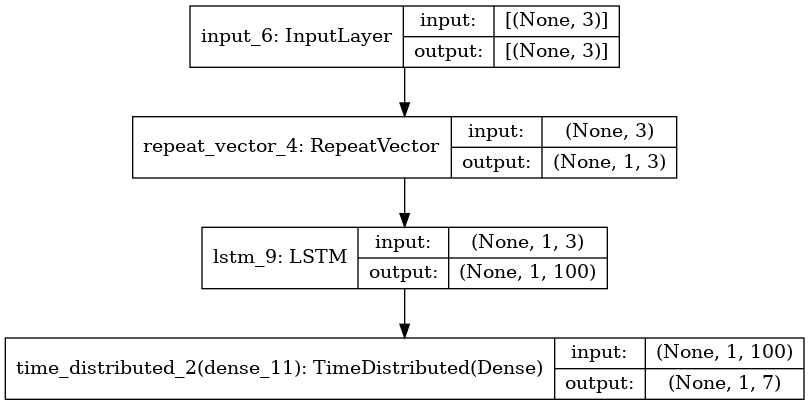

In [50]:
plot_model(decoder, show_shapes=True, to_file='VAE_FLIGHT_dense.png')

In [51]:
encode = encoder(inputs)
reconstruction = decoder(encode)
lstm_ae = Model(inputs=[inputs], outputs = [reconstruction]) 

In [52]:
lstm_ae.compile(loss="mse",
optimizer='rmsprop')

In [53]:
# fit network
# history = vae.fit(train_X, train_X, epochs=10, batch_size=600, validation_data=[test_X, test_y], verbose=1, shuffle=False)
history = lstm_ae.fit(train_X, train_X, epochs=50, batch_size=600, verbose=1, shuffle=False)

Epoch 1/50
58/58 [==============================] - 3s 5ms/step - loss: 0.3661
Epoch 2/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 3/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 4/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 5/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 6/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0134
Epoch 7/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 8/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 9/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 10/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 11/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 12/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 13/50
58/58 [==============================

In [101]:
feature_vec = encoder.predict(train_X)

In [102]:
feature_vec.shape

(34218, 3)

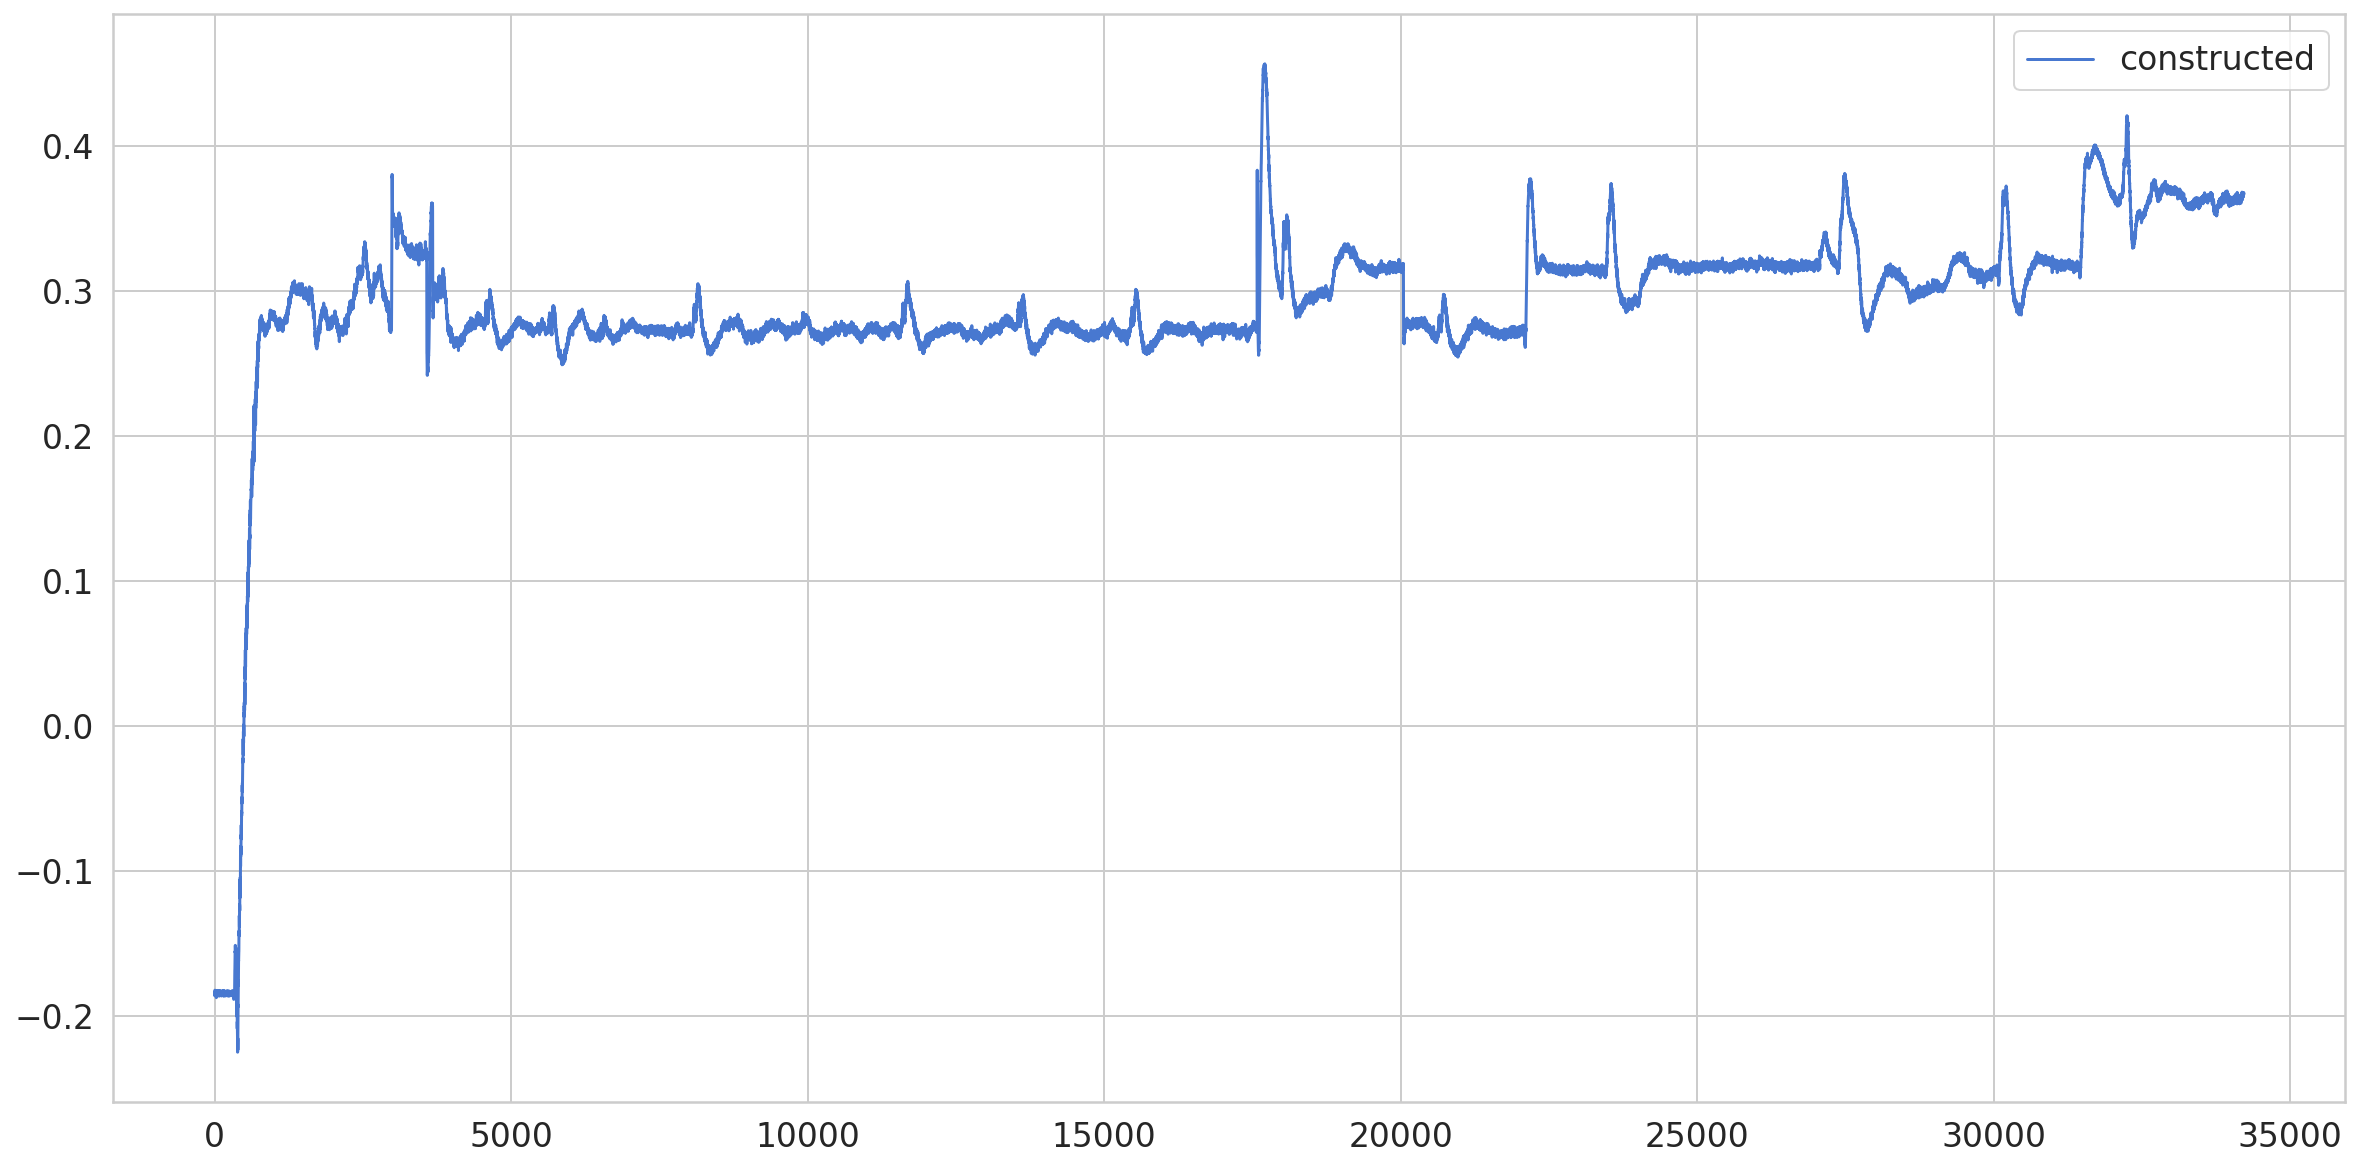

In [144]:
figure1 = plt.figure(figsize=(20,10))
plt.plot(feature_vec[:,2], label = 'constructed')
plt.legend()
# plt.grid()
plt.show()

In [104]:
x= feature_vec

In [105]:
x.shape

(34218, 3)

In [106]:
def laplace_graph(data,n_neighbors):
    
    data_size = x.shape[0]
    knn_dist_graph = kneighbors_graph(X=x,
                                 n_neighbors=n_neighbors,
                                 mode='distance',
                                 metric='euclidean',
                                 n_jobs=6)
    
    sigma = 1
    similarity_graph = sparse.csr_matrix(knn_dist_graph.shape)
    nonzeroindices = knn_dist_graph.nonzero()
    similarity_graph[nonzeroindices] = np.exp( -np.asarray(knn_dist_graph[nonzeroindices])**2 / 2.0 * sigma**2)
    similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
    degree_matrix = similarity_graph.sum(axis=1)
    diagonal_matrix = np.diag(np.asarray(degree_matrix).reshape(data_size,))
    L =  diagonal_matrix - similarity_graph
    return L
    
    

In [107]:
n = 10
L= laplace_graph(x,n)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [108]:
L.shape

(34218, 34218)

In [109]:
class elm:
    def __init__(self, input_data, nh,lamba2):
        self.input = input_data
        self.hidden_neurons= nh
        self.lambda2 = lamba2
        self.wr = np.random.rand(self.input.shape[1], self.hidden_neurons)
        self.br = np.random.rand(1, self.hidden_neurons)
        
    def sigmoid(self,x):
        return (1 / (1 + np.exp(-x)))
    
    def compute_H(self):
        H_ops = np.matmul(np.transpose(self.wr), np.transpose(self.input)) + np.transpose(self.br)
        H_ops = self.sigmoid(H_ops)
        H_ops = np.transpose(H_ops)
        return H_ops
    
    def w_star(self, H):
        a = np.linalg.inv(np.matmul(np.transpose(H), H) + self.lambda2*np.identity(self.hidden_neurons))
        b = np.matmul(np.transpose(H), self.input)
        Wx = np.matmul(a, b)
        return Wx

    def predict(self):
        wr = self.wr; br = self.br
        H = self.compute_H()
        Wx = self.w_star(H)
        a = np.matmul(np.transpose(wr), np.transpose(self.input))
        b = np.transpose(br); c = self.sigmoid(a + b)
        recons = np.matmul(np.transpose(Wx), c)
        return np.transpose(recons)

In [110]:
nh =2000
lambda2 =.001
N= x.shape[0]

In [111]:
N

34218

In [112]:
model = elm(x,nh,lambda2)

In [113]:
H= model.compute_H()

In [114]:
Ih = np.identity(nh)
Iu = np.identity(N)
lamda = 0.001


In [115]:
if nh <= N:
    A= Ih+ lamda* np.matmul(np.transpose(H),np.matmul(L,H))
    B= np.matmul(np.transpose(H),H)
    r,v = np.linalg.eig(A)
    arr1inds = r.argsort()
    v1 = v.copy()
    v2 = v1[arr1inds]
    v3 = v2[:,1:]
    vec1 = np.matmul(H,v)
    vec_norm1 = np.linalg.norm(vec1) 
    vi= v3 /vec_norm1
    W = vi
    print('weight calculated for nh<=N sample data ...')
    
else:
    
    A= Iu+ lamda* np.matmul(L,np.matmul(H,H.T))
    B= np.matmul(np.transpose(H),H)
    r,u = np.linalg.eig(A)
    arr1inds = r.argsort()
    u1 = u.copy()
    u2= u1[arr1inds]
    u3 = u2[:,1:]
    vec2 =np.matmul(H, np.matmul(H.T,u))
    vec_norm2 = np.linalg.norm(vec2)
    ui= u3/vec_norm2
    W= np.matmul(H.T,u)
    print('weight calculated for sparse sample data ...')

weight calculated for nh<=N sample data ...


In [116]:
"embedding matrix"

E = np.matmul(H,W)

In [117]:
E.shape

(34218, 1999)

In [118]:
np.set_printoptions(precision=3)

In [119]:
embed_dim = 55

In [120]:
E[:,embed_dim]

matrix([[4.697e-05+0.j],
        [4.695e-05+0.j],
        [4.697e-05+0.j],
        ...,
        [6.491e-05+0.j],
        [6.492e-05+0.j],
        [6.496e-05+0.j]])

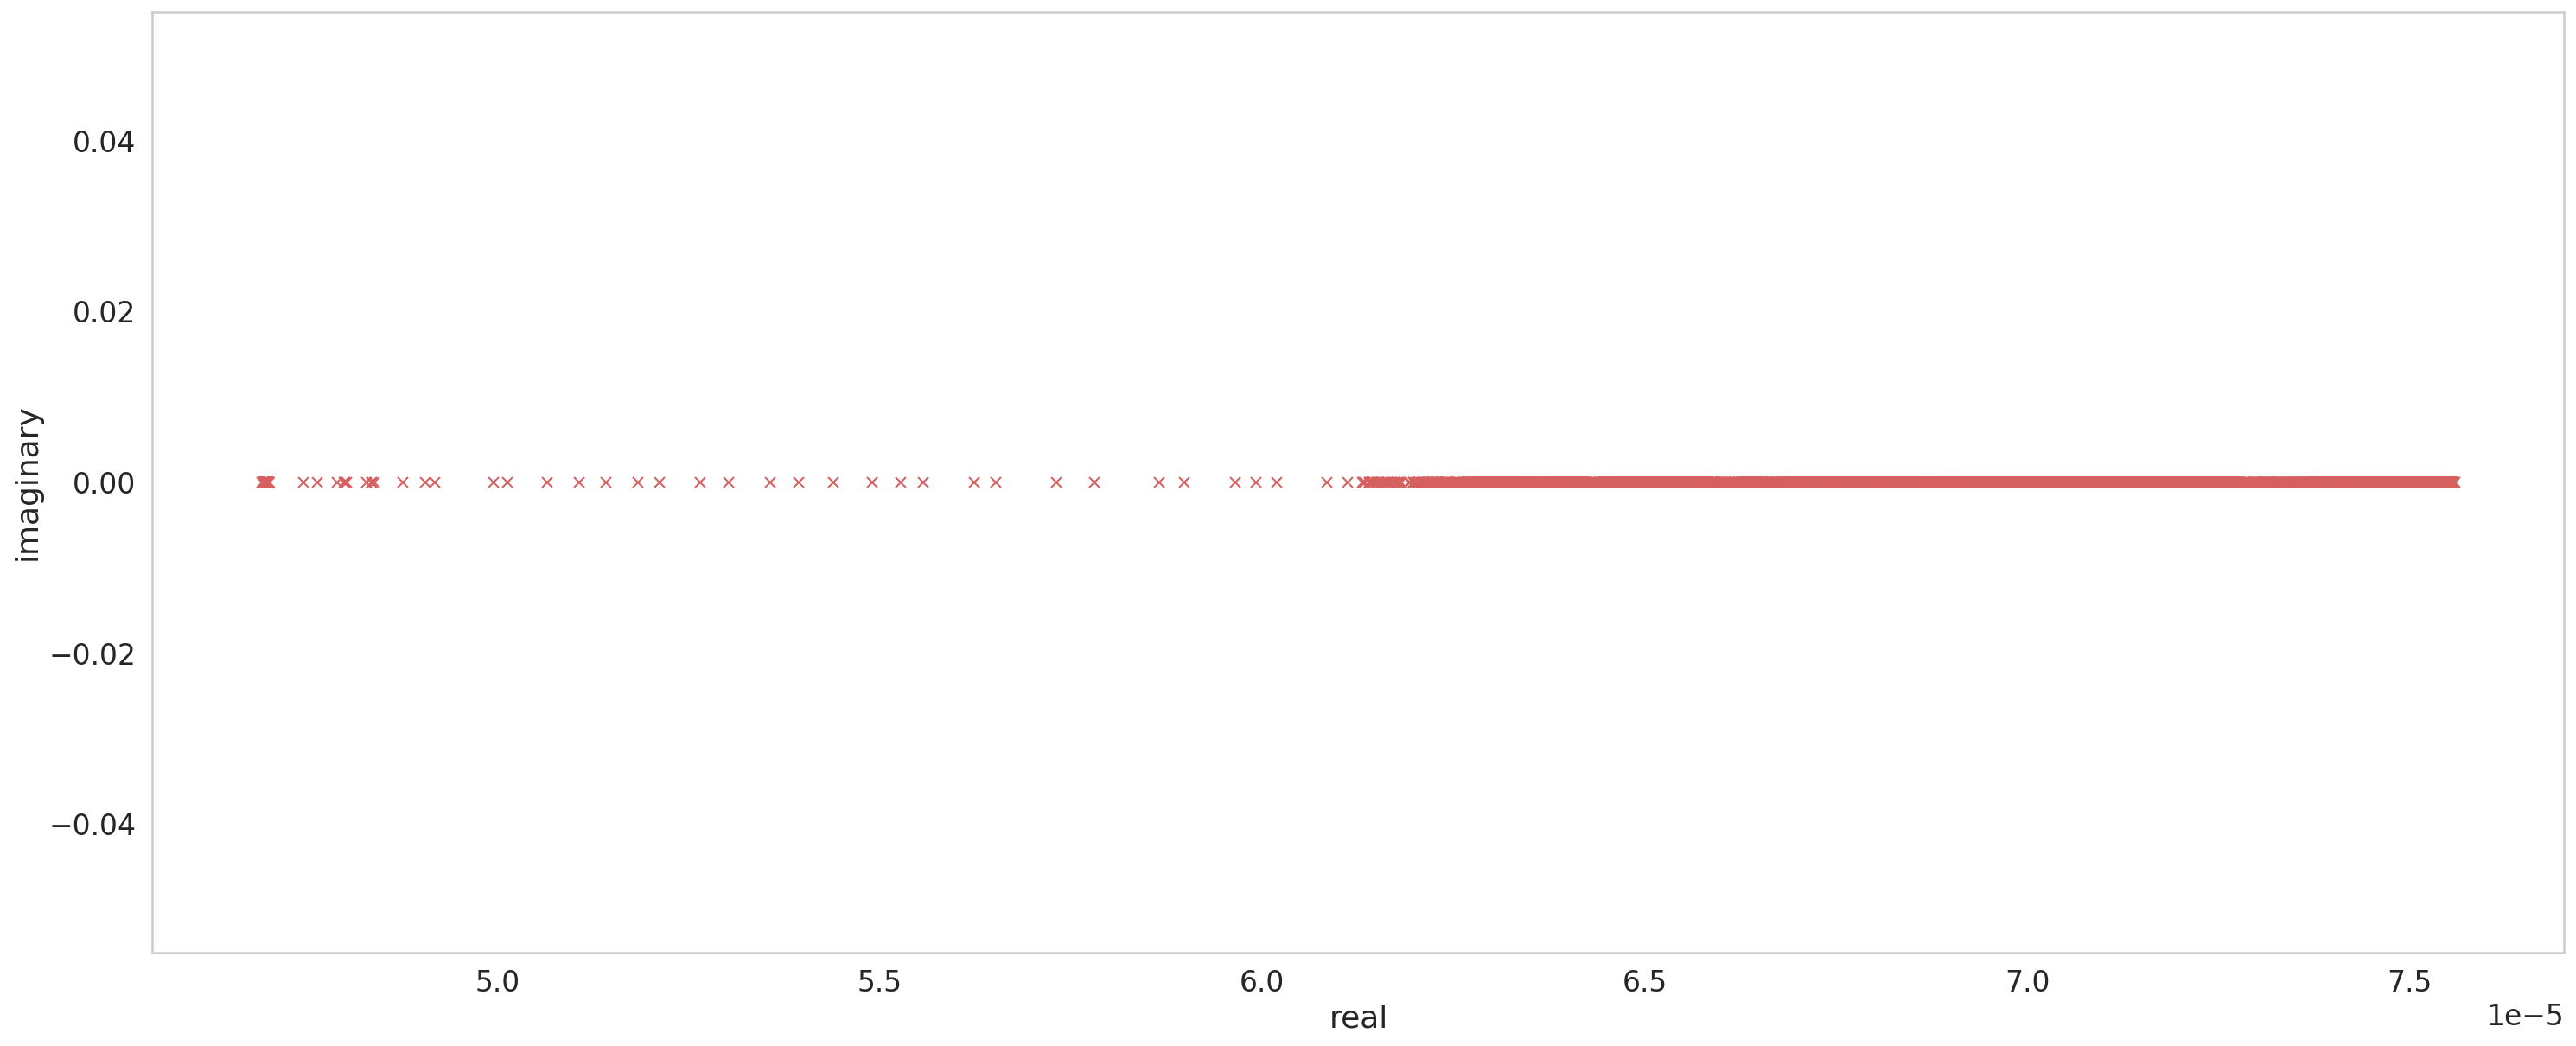

In [121]:
fig1 = plt.figure( figsize=(25, 10))
plt.plot(E[:,embed_dim].real,E[:,embed_dim].imag,'rx')
plt.xlabel('real');
plt.ylabel('imaginary');
plt.grid()

In [122]:
embed_data = np.concatenate((E[:,embed_dim].real,E[:,embed_dim].imag),axis=1)

In [123]:
emded = pd.DataFrame(embed_data)

In [124]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(emded)

In [125]:
y= pd.DataFrame(y_km)

In [135]:
anomaly_index = np.where(y_km==1)

In [136]:
anomaly_index

(array([    0,     1,     2, ..., 34215, 34216, 34217]),)

In [137]:
reframed

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.566839   0.433489        0.0        0.0       0.02   0.007475   
2       0.567173   0.433489        0.0        0.0       0.02   0.008009   
3       0.547592   0.433489        0.0        0.0       0.02   0.008009   
4       0.528025   0.433489        0.0        0.0       0.02   0.008009   
5       0.535843   0.433489        0.0        0.0       0.02   0.007475   
...          ...        ...        ...        ...        ...        ...   
42768   0.532186   0.376896        0.0        0.0       0.02   0.008009   
42769   0.530913   0.376896        0.0        0.0       0.02   0.008009   
42770   0.523458   0.376896        0.0        0.0       0.02   0.008009   
42771   0.520994   0.376896        0.0        0.0       0.02   0.007475   
42772   0.523715   0.376896        0.0        0.0       0.02   0.007475   

       var7(t-1)   var7(t)  
1       0.014033  0.010372  
2       0.010372  0.009152  
3       0.009152  0.009762  
4       0.009762  0.013423  
5       0.013423  0.010372  
...          ...       ...  
42768   0.011592  0.008542  
42769   0.008542  0.010982  
42770   0.010982  0.013423  
42771   0.013423  0.012203  
42772   0.012203  0.010372  

[42772 rows x 8 columns]

In [138]:
train_check = reframed.iloc[:n_train_msec, :]

In [139]:
train_check.shape

(34218, 8)

In [140]:
train_X.shape

(34218, 1, 7)

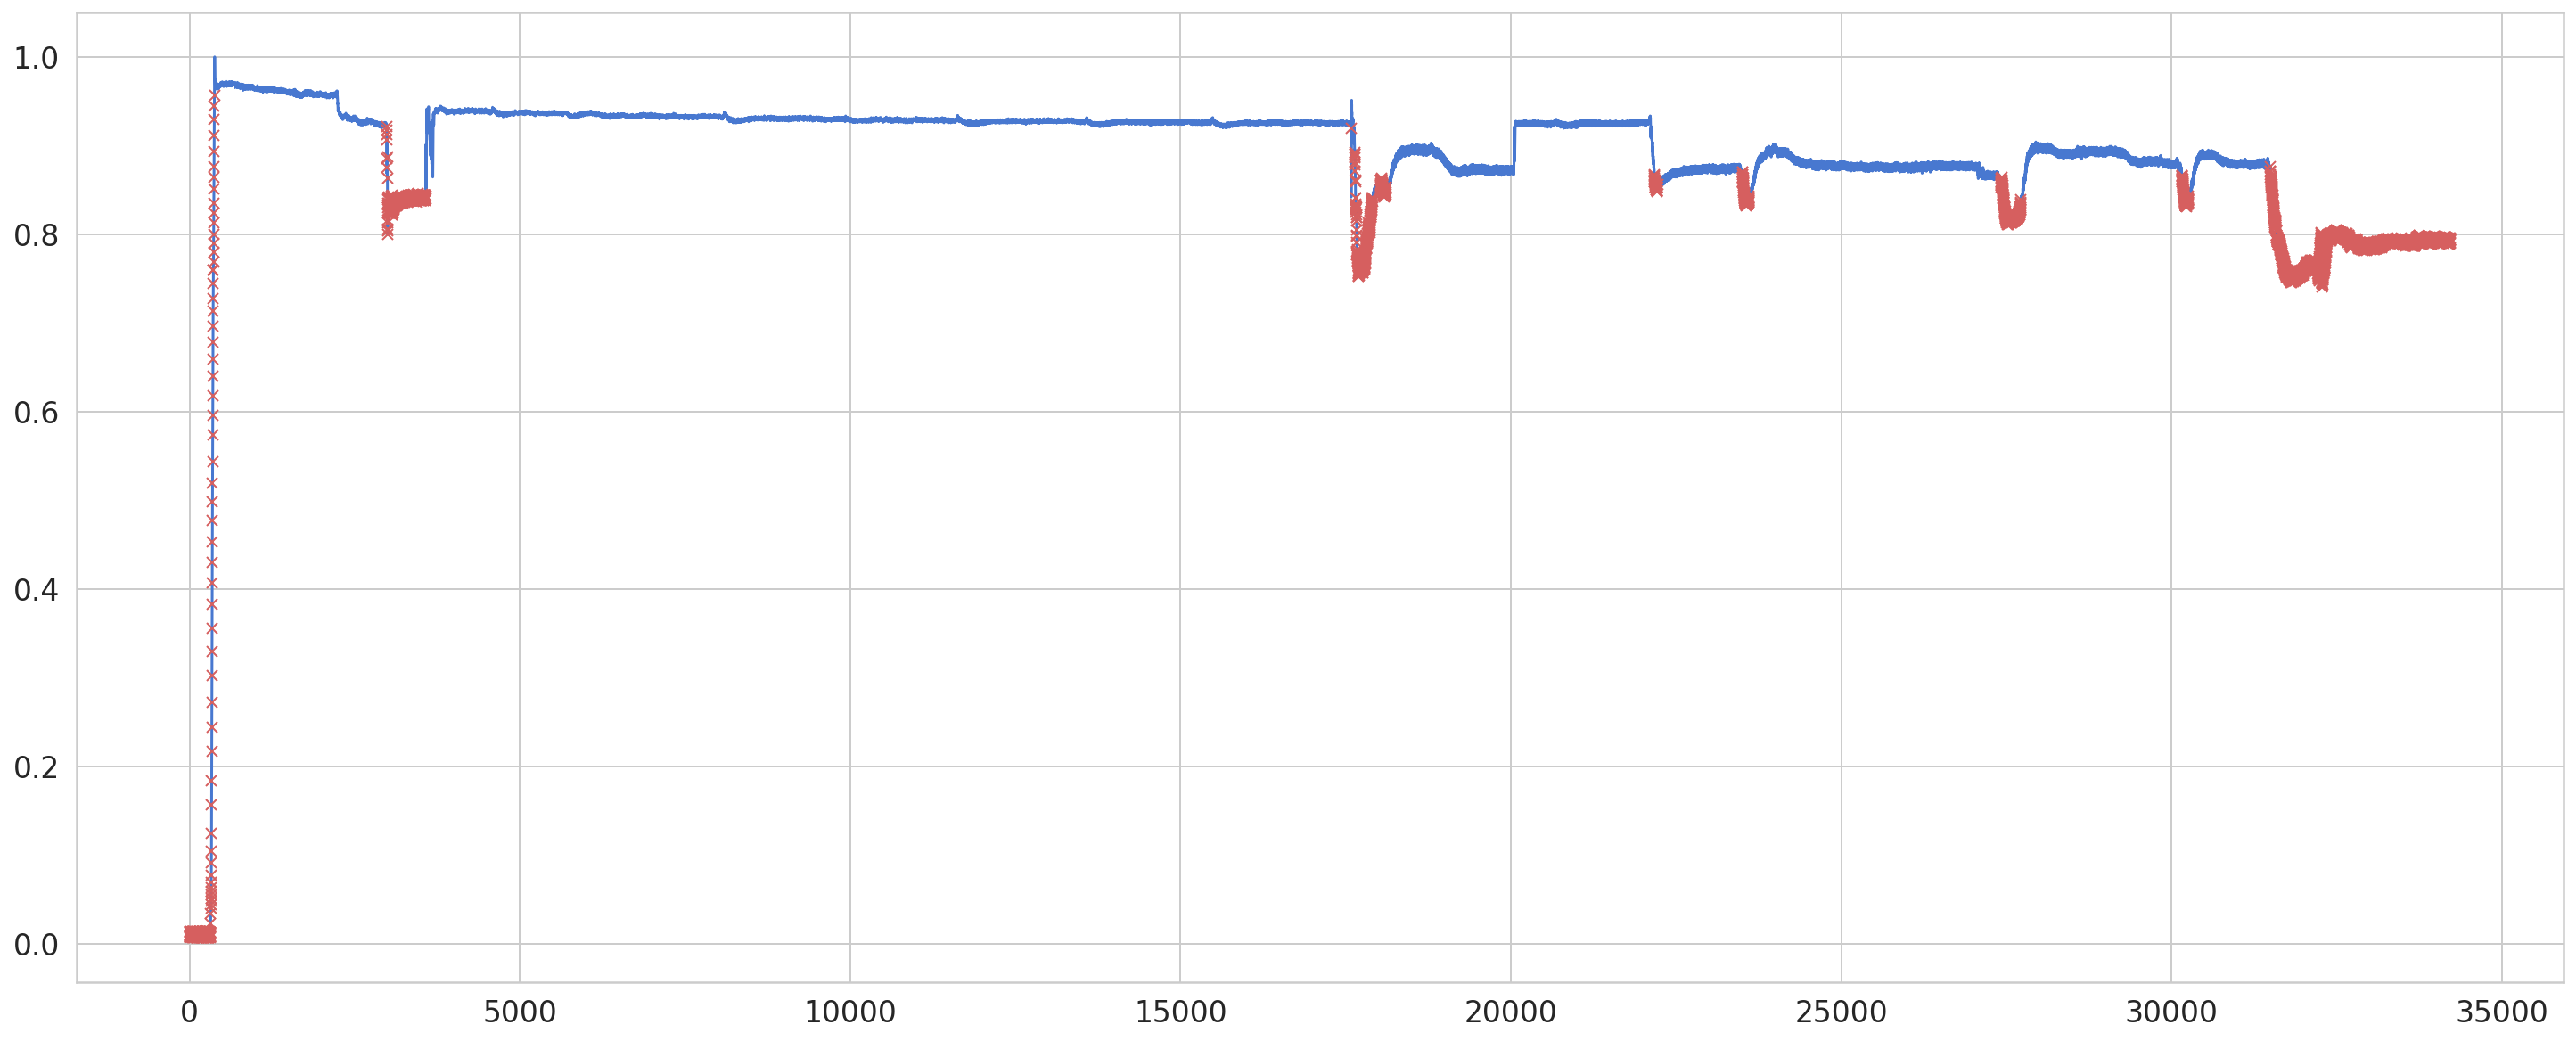

In [141]:
figure = plt.figure(figsize= [25,10])
df_subset = train_check.iloc[anomaly_index]["var7(t)"]
df_data = train_check['var7(t)']
plt.plot(df_data)
plt.plot(df_subset, 'rx')
# plt.grid()